In [1]:
### decodingCallTypes 3 uses the information from part2

In [2]:
# Dependencies 
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import multiprocessing as mp
from scipy.stats import t
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
from scipy.stats import norm
import itertools

from decoders import naiveBayes

import config

In [3]:
# Some paths
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
# rootPath = '/Users/frederictheunissen/Google Drive/julie/'
pklPath = 'pkl/'


# The 6 birds from Julie data set
birds = ['BlaBro09xxF', 'GreBlu9508M', 'WhiBlu5396M', 'LblBlu2028M', 'WhiWhi4522M', 'YelBlu6903F']

# Color code for call type
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (255/255.0, 255/255.0, 255/255.0)}



In [4]:
# Load the data base
outPath = rootPath+'JulieDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

/Users/frederictheunissen/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']
# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

In [6]:
# read unitList and argList2 and Confusion matrices data base
inPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList.pkl' 
fileIn = open(inPath,"rb")
argList2 = pk.load(fileIn)
unitList = list(pk.load(fileIn))

fileIn.close()

In [7]:
# read unitList and argList10 and Confusion matrices data base
inPath = rootPath+ pklPath + 'JulieDataBaseGoodUnitList10.pkl' 
fileIn = open(inPath,"rb")
argList10 = pk.load(fileIn)
unitList10 = list(pk.load(fileIn))

fileIn.close()

In [8]:
print(len(unitList))
print(len(unitList10))

408
375


In [9]:
siteList = pd.read_csv(rootPath+'h5_listFiles_CallProtocol.txt', sep='\s+', header=None, names = ['CellNumber', 'Path'])

birdL = []
siteL = []

for path in siteList['Path']:
    pathSplit = path.split("/")
    bird = pathSplit[5]
    site = (pathSplit[6].split('.')[0])[0:-3]
    birdL.append(bird)
    siteL.append(site)

In [10]:
# Printing the name of the most discriminating units
birdName = []
for unit in unitList10:
    ind = siteL.index(unit[0:-7])
    birdName.append(birdL[ind])
    
birdUnique = np.unique(birdName)
for bird in birdUnique:
    print(bird, ":", len([x for x in birdName if x == bird]))

BlaBro09xxF : 21
GreBlu9508M : 171
WhiWhi4522M : 83
YelBlu6903F : 100


In [11]:
# Generates the common stimulus set
def commonStim(siteUnit, unitList):
      
    for i, unit in enumerate(unitList):
        tempStims = np.unique(dfDataBaseNW['stim'][siteUnit==unit].values)
        if i == 0 :
            stimSet = set(tempStims)
        stimSet = stimSet.intersection(tempStims)
                               
    return stimSet
        

In [38]:
# We are doing 1,2,3,4,5,10,15
numUnits = 2

#nGood = len(unitList)
nGood = len(unitList10)

maxTest = 2000  # This is 10000 in version 1 and 1800 for version 2 (with more permutations)
nBirds = len(birdUnique)
argListBirds = [[] for i in range(nBirds)]
ntests = np.zeros((nBirds,), dtype=int)

siteUnit = (dfDataBaseNW['site']+'_'+dfDataBaseNW['unit'])
#nGoodPairs = len(argList2)
nGoodPairs = len(argList10)

# For more than 3 units look for previous combinations that worked
if numUnits > 3 :
    foundFile = False
    testUnits = numUnits - 1
    while not foundFile: 
        pathIn = rootPath + pklPath + 'JulieDataBase%dGoodUnitPCPerBird.pkl' % testUnits
        if os.path.exists(pathIn) :
            foundFile = True
            fileIn = open(pathIn, 'rb')
            argListBirdsPrev = pk.load(fileIn)
            fileIn.close()
            print('Found file from previous run')
        else:
            testUnits -= 1
            

for ibird, bird in enumerate(birdUnique):
    nGoodBird = len([x for x in birdName if x == bird])
    
    if nGoodBird < numUnits:
        continue
        
    xtests = comb(nGoodBird,numUnits)
    if xtests > maxTest:
        ntests[ibird] = maxTest + 1
    else:
        ntests[ibird] = int(xtests)

    # Generate the good index for this bird
    indGoodBird = [ind for ind, birdlist in enumerate(birdName) if birdlist == bird]
    unitListBird = [unitList10[i] for i  in indGoodBird]

    # Generate the list of arguments to run naiveBayes in parallel
    argList = argListBirds[ibird]
    if numUnits == 1:
        for i, unit in enumerate(unitListBird):
            if i == ntests[ibird]:
                break
            unitChoice = [unit]
            argList.append(unitChoice)
    elif numUnits == 2:  
        for i1, unit1 in enumerate(unitListBird):
            if i1 == ntests[ibird]:
                break
            for i2, unit2 in enumerate(unitListBird):
                if i2 <= i1:
                    continue
                if i2 == ntests[ibird]:
                    break
                unitChoice = [unit1, unit2]
                stimSet = commonStim(siteUnit, unitChoice)
                if len(stimSet) > 100 :
                    argList.append(unitChoice)
    elif (numUnits == 3 and ntests[ibird] <= maxTest):      
        # Generate all possible combinations
        for unitChoice in itertools.combinations(unitListBird, numUnits):
            stimSet = commonStim(siteUnit, unitChoice)
            if len(stimSet) > 100 :
                argList.append(list(unitChoice))
    else:
        i = 0
        while i < ntests[ibird]:
            
            if (numUnits == 3 or not foundFile ):
                # Choose 1rst one randomly to get going
                unitChoice = [unitListBird[np.random.randint(nGoodBird)]]
            else:
                # Choose the first few from previous run                
                unitChoice = argListBirdsPrev[ibird][np.random.randint(len(argListBirdsPrev[ibird]))]
                if (i==0):
                    print('Starting choice:', unitChoice)
    
            # choose additional ones, one by one:
            unitListTest = unitListBird.copy()
            while (len(unitChoice) < numUnits) & (len(unitListTest) > 0) :
                newUnit = np.random.choice(unitListTest, 1, replace=False)
                if newUnit in unitChoice:
                    unitListTest.remove(newUnit)
                    continue

                unitChoiceTemp = unitChoice.copy()
                unitChoiceTemp.append(newUnit[0])
        
                stimSet = commonStim(siteUnit, unitChoiceTemp)
                if len(stimSet) > 100 :
                    unitChoice.append(newUnit[0])
                else:
                    unitListTest.remove(newUnit)
    
            if (len(unitChoice) == numUnits) & (unitChoice not in argList):
                argList.append(unitChoice)
                i += 1
                if (i%100 == 0 ):
                    print(i, '...')



Found file from previous run
Starting choice: ['Site1_L1500R1500_e17_s0_ss1', 'Site1_L1500R1500_e20_s1_ss1', 'Site3_L2500R2300_e22_s0_ss1', 'Site1_L1500R1500_e20_s0_ss2', 'Site2_L2000R1600_e3_s1_ss2', 'Site1_L1500R1500_e3_s1_ss1', 'Site2_L2000R1600_e17_s1_ss2', 'Site2_L2000R1600_e21_s1_ss1', 'Site2_L2000R1600_e14_s2_ss2', 'Site3_L2500R2300_e22_s1_ss3']
100 ...
200 ...
300 ...
400 ...
500 ...
600 ...
700 ...
800 ...
900 ...
Starting choice: ['Site5_L1800R2100_e29_s0_ss4', 'Site2_L1100R1450_e2_s0_ss1', 'Site2_L1100R1450_e6_s0_ss1', 'Site3_L1250R1650_e24_s0_ss1', 'Site2_L1100R1450_e28_s0_ss2', 'Site2_L1100R1450_e3_s0_ss1', 'Site1_L750R1100_e19_s0_ss3', 'Site2_L1100R1450_e11_s0_ss1', 'Site4_L1500R1900_e28_s0_ss3', 'Site4_L1500R1900_e18_s0_ss1']
100 ...
200 ...
300 ...
400 ...
500 ...
600 ...
700 ...
800 ...
900 ...
Starting choice: ['Site3_L1900R1800_e23_s0_ss3', 'Site2_L1500R1450_e30_s0_ss1', 'Site4_L2100R2050_e17_s0_ss1', 'Site4_L2100R2050_e32_s0_ss1', 'Site3_L1900R1800_e26_s0_ss1', 'Sit

In [36]:
comb(171, 15)

1.270270170488752e+21

In [39]:
# Run the decoders using multiprocessors if possible
mpflag = True

# Run Naive Bayes in chunks of 90 with a pool of 30 workers
chunckSize = 100    # A chunk size of 100 is used for memory since it has to keep the results of all or 90 and 1800 tests.
poolSize = 30       # 10 for laptop, 30 for desktop

# Allocate memory for results
pccBirds = []
selHBirds = []
confMatTotBirds = []



for ibird, bird in enumerate(birdUnique):
    
    # Allocate bird specific storage for the results
    pcc = np.zeros((ntests[ibird],))
    selH = np.zeros((ntests[ibird],))
    confMatTot = np.zeros((ncalls, ncalls))
    confMatCount = 0
    
    # Calculate the number of chunks
    nchunks = ntests[ibird]//chunckSize
    if ntests[ibird] % chunckSize:
        nchunks += 1
        
    # Arglist for this bird
    argList = argListBirds[ibird]
    
    
    if mpflag == True:
        if __name__ == '__main__':
            for ichunk in range(nchunks):
                istart = ichunk*chunckSize
                iend = (ichunk+1)*chunckSize
                if iend > ntests[ibird]:
                    iend = ntests[ibird]         
        
                with mp.Pool(poolSize) as p:
                    results = p.map(naiveBayes, argList[istart:iend])
        
            # I don't think I need these??
            # p.close()
            # p.join()
        
                for i, res in enumerate(results):
                    confMat = res[1]
                    if (confMat.shape == (ncalls,ncalls) ):
                        pcc[istart + i] = res[0]
                        pccDiag = np.diag(confMat)
                        pccDiag = pccDiag/np.sum(pccDiag)
                        pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
                        selH[istart + i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
                        testsPerClass = res[2]
                        confMatTot = np.add(confMatTot, confMat)
                        confMatCount += testsPerClass
                
                print('Done with chunk %d/%d for bird %d/%d' % (ichunk+1, nchunks, ibird+1, nBirds))
    else:
        for i in range(ntests[ibird]):
            pccval, confMat, testsPerClass = naiveBayes(argList[i], code = code)
            pcc[i] = pccval
            pccDiag = np.diag(confMat)
            pccDiag = pccDiag/np.sum(pccDiag)
            pccDiag[pccDiag == 0] = 1. # Because 0log0 = 0
            selH[i] = 1 - np.sum(-pccDiag*np.log2(pccDiag))/(np.log2(ncalls))
            confMatTot = np.add(confMatTot, confMat)
            confMatCount += testsPerClass

    # Calculate the average confusion matrix. 
    for i in range(ncalls):
        if confMatCount[i] > 0:
            confMatTot[i,:] = confMatTot[i,:]/confMatCount[i]
            
    # Store the results in the bird lists
    pccBirds.append(pcc)
    selHBirds.append(selH)
    confMatTotBirds.append(confMatTot)
    
        
# save the PC and Confusion matrices data base
outPath = rootPath + pklPath + 'JulieDataBase%dGoodUnitPCPerBird.pkl' % numUnits
fileOut = open(outPath,"wb")
pk.dump(argListBirds, fileOut)
pk.dump(confMatTotBirds, fileOut)
pk.dump(pccBirds, fileOut)
pk.dump(selHBirds, fileOut)
pk.dump(birdUnique, fileOut)
fileOut.close()



Done with chunk 1/9 for bird 1/4
Done with chunk 2/9 for bird 1/4
Done with chunk 3/9 for bird 1/4
Done with chunk 4/9 for bird 1/4
Done with chunk 5/9 for bird 1/4
Done with chunk 6/9 for bird 1/4
Done with chunk 7/9 for bird 1/4
Done with chunk 8/9 for bird 1/4
Done with chunk 9/9 for bird 1/4
Done with chunk 1/9 for bird 2/4
Done with chunk 2/9 for bird 2/4
Done with chunk 3/9 for bird 2/4
Done with chunk 4/9 for bird 2/4
Done with chunk 5/9 for bird 2/4
Done with chunk 6/9 for bird 2/4
Done with chunk 7/9 for bird 2/4
Done with chunk 8/9 for bird 2/4
Done with chunk 9/9 for bird 2/4
Done with chunk 1/9 for bird 3/4
Done with chunk 2/9 for bird 3/4
Done with chunk 3/9 for bird 3/4
Done with chunk 4/9 for bird 3/4
Done with chunk 5/9 for bird 3/4
Done with chunk 6/9 for bird 3/4
Done with chunk 7/9 for bird 3/4
Done with chunk 8/9 for bird 3/4
Done with chunk 9/9 for bird 3/4
Done with chunk 1/9 for bird 4/4
Done with chunk 2/9 for bird 4/4
Done with chunk 3/9 for bird 4/4
Done with 

In [40]:
for ibird in range(nBirds):
    print(np.mean(pccBirds[ibird]))

48.248642922174355
55.71195406515959
54.17260034511633
56.05802282373405


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


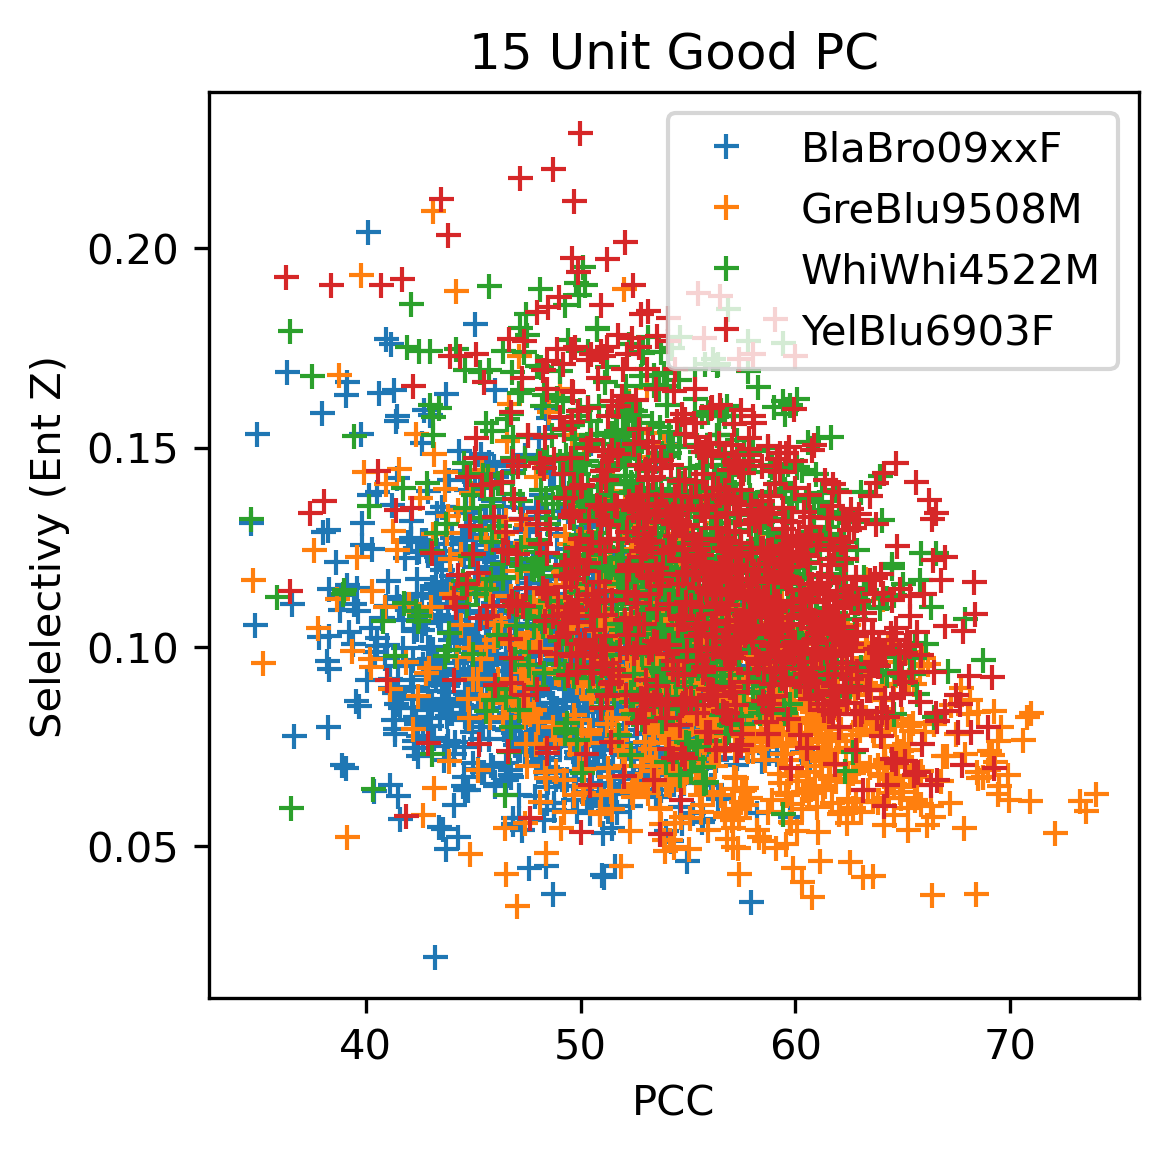

In [41]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for ibird, bird in enumerate(birdUnique):
    ax.plot(pccBirds[ibird], selHBirds[ibird], '+', label = bird)

ax.set_xlabel('PCC')
ax.set_ylabel('Selelectivy (Ent Z)')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/scatterPCCSelJ%dUnitGoodPCPerBird.eps' % numUnits)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


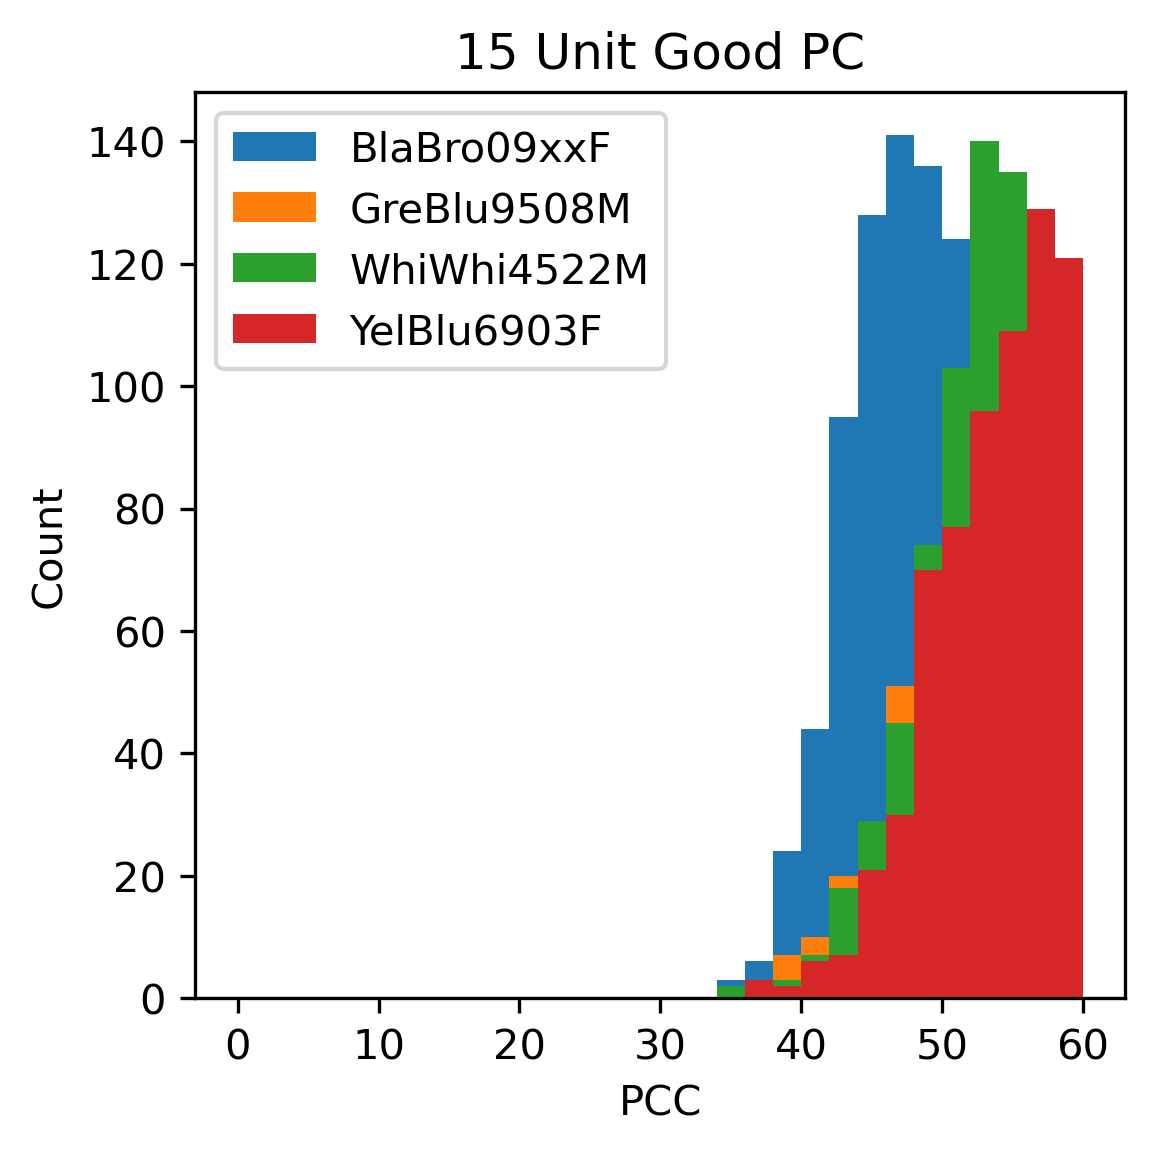

In [42]:
fig = plt.figure(figsize=(4,4), dpi=300)
ax = fig.subplots()

for ibird, bird in enumerate(birdUnique):
   ax.hist(pccBirds[ibird], bins = 30, range = (0,60), label=bird)

ax.set_xlabel('PCC')
ax.set_ylabel('Count')
ax.set_title('%d Unit Good PC' % numUnits)
ax.legend()

plt.savefig('/Users/frederictheunissen/Desktop/pcchistJ%dUnitGoodPCPerBird.eps' % numUnits)

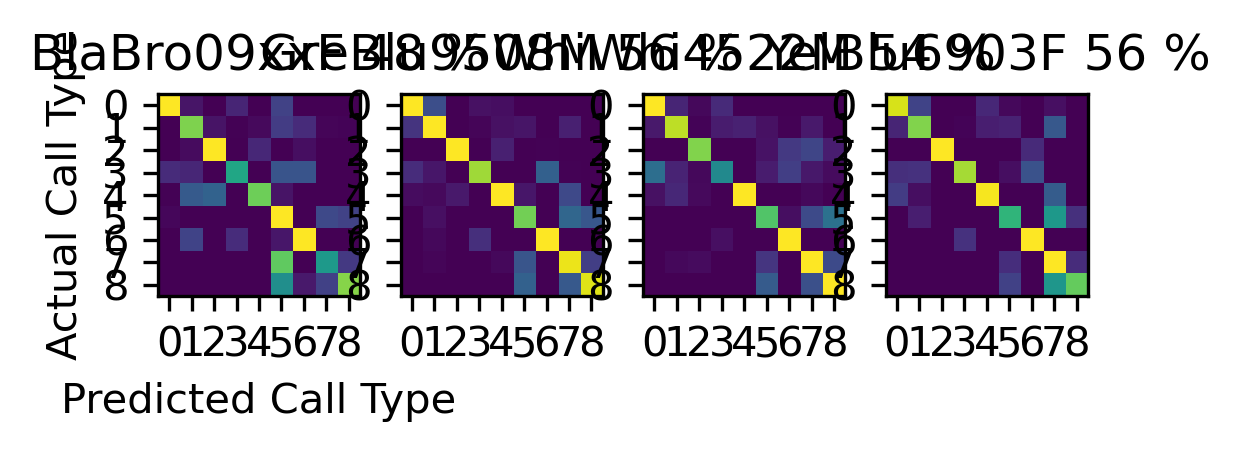

In [44]:
# Plot the overall confusion matrix

cmap='viridis'
fig = plt.figure(figsize=(4,12), dpi=300)
axBirds = fig.subplots(1, nBirds)

for ibird, bird in enumerate(birdUnique):
    ax = axBirds[ibird]
    im_ = ax.imshow(confMatTotBirds[ibird]*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 50)

    # if ibird == (nBirds-1) :
    #    fig.colorbar(im_, ax=ax)
    
    if ibird == 0 :
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               # xticklabels=callNames,
               # yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%s %.0f %%' % (bird, np.mean(pccBirds[ibird])))
    else:
        ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               # xticklabels=callNames,
               # yticklabels=callNames,
               # ylabel="Actual Call Type",
               # xlabel="Predicted Call Type",
               title='%s %.0f %%' % (bird, np.mean(pccBirds[ibird])))
        

plt.savefig('/Users/frederictheunissen/Desktop/confMatJ%dUnitGoodPCPerBird.eps' % numUnits)

